In [17]:
from unstructured.partition.auto import partition
from unstructured.partition.pdf import partition_pdf
from google import genai
from google.genai import types
import numpy as np
import chromadb
from dotenv import load_dotenv, dotenv_values

### Data Extraction from PDF

In [18]:
file_path = 'examples/maxwell-ems-school-improvement-2023.pdf'

elements = partition_pdf(
    filename=file_path, 
    strategy='hi_res',
    infer_table_structure=True,
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,
    chunking_strategy="by_title",
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000
    )

In [19]:
set([str(type(el)) for el in elements])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [20]:
# TODO images are not always extracted correctly  (maybe extract images from pdf and get text using dedicated process)

# Each element is a chunk represented by a CompositeElement, which is used to store multiple elements of different types (Text, Image, Table, etc.)
for el in elements:
    print(type(el))
    print(el.to_dict())
    

<class 'unstructured.documents.elements.CompositeElement'>
{'type': 'CompositeElement', 'element_id': '8f66703fe2f955c3a7969d57acfd120e', 'text': 'Southeast District Cre Together We Serve\n\nMAXWELL SCHOOL IMPROVEMENT PLAN\n\nMaxwell Eagles S.O.A.R.\n\nSEPTEMBER 1, 2023\n\nDR. HYDE, PRINCIPAL; MR. EL-SHAAKIR, ASSISTANT PRINCIPAL DoDEA Americas Southeast District\n\nSchool Improvement Plan Framework\n\nVision/Mission\n\nThis document is Maxwell’s School Improvement Plan (SIP). The Plan is a roadmap and means to achieve the school’s vision and the attendant goals that follow from it. The vision, which follows directly from the District Improvement Plan (DIP), focuses on students, staff, and parents, which are three primary school stakeholders. The vision addresses broad, important outcomes for each group; they are achieving students, thriving staff, and engaged parents. The Plan also has a mission statement that guides the development of the strategies and actions necessary to achieve th

In [21]:
import pprint

pp = pprint.PrettyPrinter(indent=4)

for el in elements:
    pp.pprint(el.metadata.orig_elements)
    print("*" * 100)

[   <unstructured.documents.elements.Image object at 0x7d015f9ac710>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7d015f9ace90>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7d015fd03290>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7d015fd01460>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7d015feda5a0>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7d015fedb8c0>,
***************************************************************************

In [22]:
# Looking at the extracted tables

original_elements = []

for el in elements:
    original_elements += el.metadata.orig_elements
    
tables = [el.metadata.text_as_html for el in original_elements if 'Table' in str(type(el))]

for i in range(len(tables)):
    f = open(f"/home/mylee2662/Documents/education_walkthrough_lead/tables/table_{i}.html", 'w')
    f.write(tables[i])
    f.close

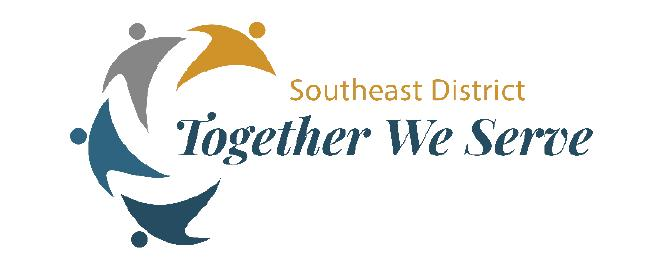

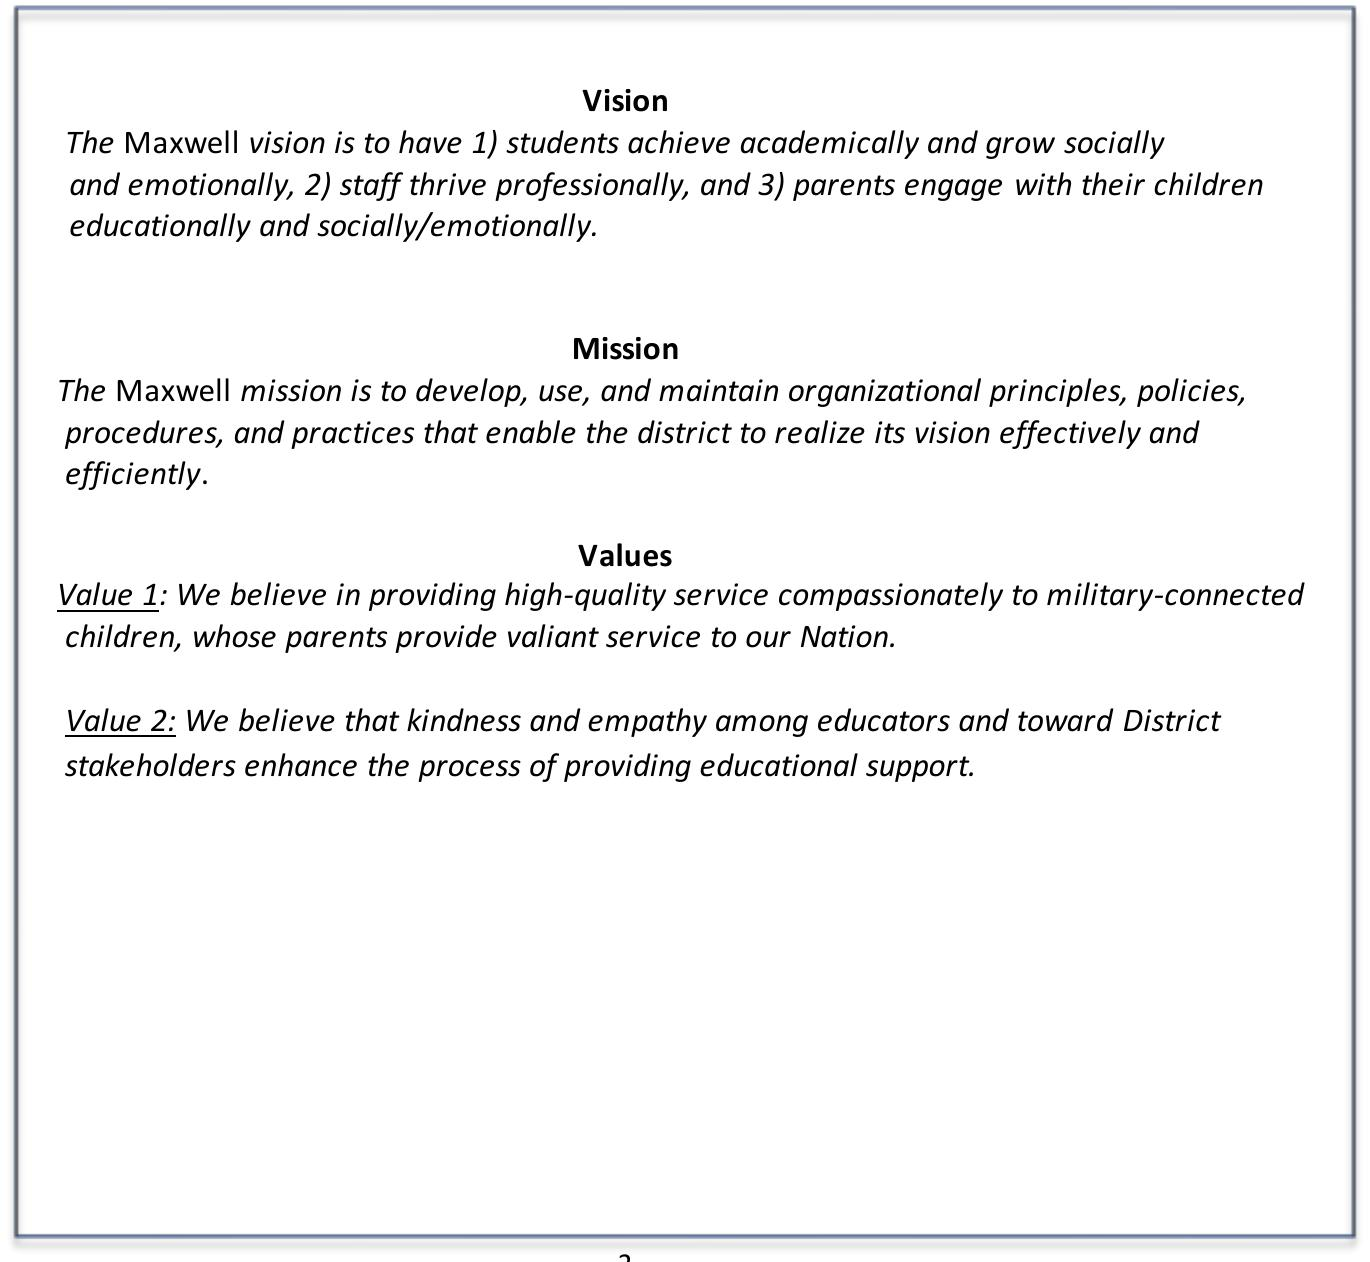

In [23]:
import base64
from IPython.display import Image, display

images = [el.metadata.image_base64 for el in original_elements if 'Image' in str(type(el))]

for i in range(len(images)):
    img_data = base64.b64decode(images[i])
    display(Image(data=img_data))

    f = open(f"/home/mylee2662/Documents/education_walkthrough_lead/images/image_{i}.webp", 'wb')
    f.write(img_data)
    f.close

In [24]:
texts = [el for el in elements if 'CompositeElement' in str(type(el))]

for text in texts:
    print(text)
    print('*' * 100)

Southeast District Cre Together We Serve

MAXWELL SCHOOL IMPROVEMENT PLAN

Maxwell Eagles S.O.A.R.

SEPTEMBER 1, 2023

DR. HYDE, PRINCIPAL; MR. EL-SHAAKIR, ASSISTANT PRINCIPAL DoDEA Americas Southeast District

School Improvement Plan Framework

Vision/Mission

This document is Maxwell’s School Improvement Plan (SIP). The Plan is a roadmap and means to achieve the school’s vision and the attendant goals that follow from it. The vision, which follows directly from the District Improvement Plan (DIP), focuses on students, staff, and parents, which are three primary school stakeholders. The vision addresses broad, important outcomes for each group; they are achieving students, thriving staff, and engaged parents. The Plan also has a mission statement that guides the development of the strategies and actions necessary to achieve the vision. Finally, two value statements reflect the school’s purpose and beliefs, which are to deliver high- quality service with empathy and kindness.

Vision T

In [25]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

load_dotenv()

summarization_model = ChatOpenAI(model="gpt-4o")

table_summarization_prompt = ChatPromptTemplate.from_template(
    """
    You are an assistant tasked with summarizing tables and text.
    Give a concise summary of the table or text.

    Respond only with the summary, no additionnal comment.
    Do not start your message by saying "Here is a summary" or anything like that.
    Just give the summary as it is.

    Table or text chunk: {element}
    """
)

table_summarize_chain = {"element": lambda x: x} | table_summarization_prompt | summarization_model | StrOutputParser()

img_summarization_prompt_text = """Describe the image in detail. For context,
                  the image is part of a school district's improvement plan document.
                  Be specific about graphs and text content.
                  Respond only with the description of the image, no additional comment.
                  """

img_summarization_messages = [
    (
        "user",
        [
            {
                "type": "text",
                "text": img_summarization_prompt_text
            },
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"}
            }
        ]
    )
]

img_summarization_prompt = ChatPromptTemplate.from_messages(img_summarization_messages)

img_summarize_chain = img_summarization_prompt | summarization_model | StrOutputParser()

In [26]:
table_summaries = table_summarize_chain.batch(tables)
pp.pprint(table_summaries)

[   'The table outlines goals and strategies across different domains for '
    'students, staff, and parents. It highlights objectives in math (64%) and '
    'ELA, with specifics in writing and language conventions. Emotional '
    'well-being goals are forthcoming. Staff focus includes teacher pedagogy '
    'with specific LWT and FCOT indicators, while faculty involvement indices '
    'are also measured. Parent engagement is assessed through survey '
    'questions, with outlined strategies such as math teaching practices, '
    'writing frameworks, targeted support for staff, and a communication plan '
    'for parents.',
    'The table highlights student goals focused on high academic achievement '
    'in literacy and math. For literacy, the objective is to increase the '
    'average school-wide writing score from the current 36 to 45 by SY 25/26, '
    'surpassing the multi-year average of 35. In math, the goal is to maintain '
    'or achieve a 64% success rate by SY 25/26, 

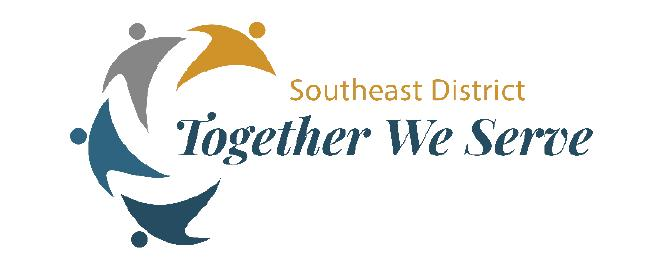

The image features a logo with abstract human figures and circular design elements in three colors: grey, gold, and blue, arranged in a semicircle. To the right of this design, the text reads "Southeast District" in gold and "Together We Serve" in blue, stylized font. The overall design conveys a sense of unity and collaboration.


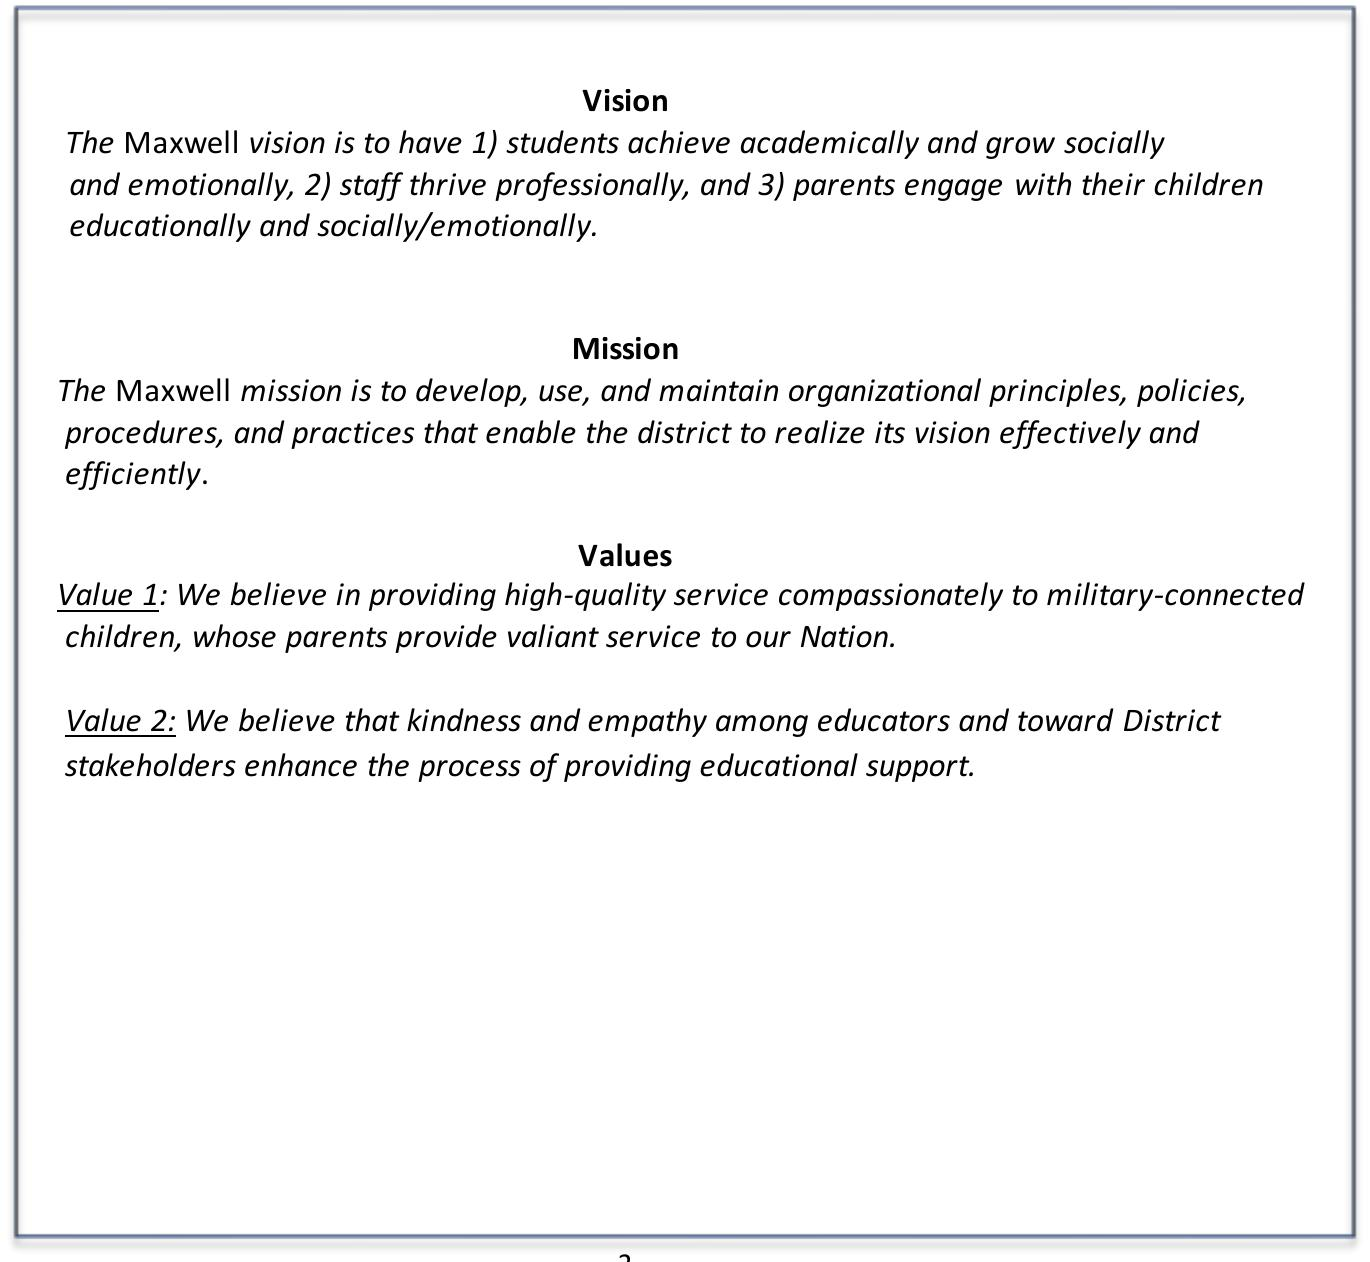

The image displays an excerpt from a document related to a school district's improvement plan. It is structured in three sections: Vision, Mission, and Values.

**Vision**:
- The vision is stated as three goals:
  1. Students achieving academically and growing socially and emotionally.
  2. Staff thriving professionally.
  3. Parents engaging with their children educationally and socially/emotionally.

**Mission**:
- The mission of the Maxwell district is to develop, use, and maintain organizational principles, policies, procedures, and practices that help realize the district's vision effectively and efficiently.

**Values**:
- **Value 1**: Emphasizes providing high-quality service to military-connected children, whose parents valiantly serve the nation.
- **Value 2**: Focuses on promoting kindness and empathy among educators and district stakeholders to enhance educational support.


In [27]:
image_summaries = img_summarize_chain.batch(images)
for i in range(len(images)):
    img_data = base64.b64decode(images[i])
    display(Image(data=img_data))
    print(image_summaries[i])

# pp.pprint(image_summaries)

### Embed Data

In [28]:
load_dotenv()

gemini_client = genai.Client()

text = [el.text for el in elements]
ids = [el.to_dict()['element_id'] for el in elements]
metadatas = [el.metadata for el in elements]


embeddings = [
    np.array(el.values) for el in gemini_client.models.embed_content(
        model="gemini-embedding-001",
        contents=text[0:100]).embeddings
]

print(embeddings)

[array([-0.00091344,  0.00703144,  0.027333  , ...,  0.00525507,
        0.00117632,  0.0104392 ], shape=(3072,)), array([ 0.00119456,  0.02060773,  0.03048684, ...,  0.01277341,
        0.00486763, -0.00211733], shape=(3072,)), array([ 0.0036871 ,  0.00840058,  0.0255983 , ...,  0.01171447,
        0.00298586, -0.00241   ], shape=(3072,)), array([ 0.00804218,  0.02098288,  0.01397029, ...,  0.0028717 ,
        0.00108104, -0.00116603], shape=(3072,)), array([-0.00129753,  0.0370096 ,  0.02867194, ..., -0.01855901,
        0.00952995,  0.00647407], shape=(3072,)), array([-0.00133742,  0.01821844,  0.02704013, ..., -0.00802118,
       -0.00059782,  0.00538394], shape=(3072,)), array([0.00548619, 0.02487488, 0.02124529, ..., 0.00539258, 0.01484588,
       0.00104102], shape=(3072,)), array([ 0.02077708,  0.03298363,  0.00987267, ..., -0.00150344,
        0.00985042,  0.00675413], shape=(3072,)), array([ 0.00915602,  0.02409054,  0.01995681, ..., -0.01626706,
        0.00292466,  0.009613

### Store Embeddings in Chroma DB

In [29]:
chroma_client = chromadb.Client()
collection = chroma_client.create_collection(
    name="demo_collection",
    )
collection.add(
    embeddings=embeddings,
    ids=ids[0:100],
    documents=text[0:100]
)


### Retrieve from Chroma DB

In [30]:
query = "What are the district goals associated with Community Partnerships??"

embedded_query = [
    np.array(el.values) for el in gemini_client.models.embed_content(
    model="gemini-embedding-001",
    contents=query).embeddings
]

print(embedded_query)

results = collection.query(
    query_embeddings=embedded_query,
    n_results=10
)

print(results["documents"])

[array([-0.02243633,  0.0190365 ,  0.00832912, ..., -0.01428838,
        0.01118476, -0.00128035], shape=(3072,))]
[['Vision Area 3: Parent Engagement\n\nParent Goals and Objectives\n\nTable 25: Parent Goals and Objectives\n\nObjectives Parent Goals Data Source Domain and Measure Rationale Goal Target Score & Date Population Parents will be informed about and involved in their child’s learning. 3.1 C&E Parent Survey Q1, Q2, Q3 ▪ Q1, Q2: Percent Well ▪ Q3: Percent Quite-a-lot Scores for these questions have been relatively flat since SY20/21 and below a desirable threshold score of 80%. Achieve a School-wide percent observed score of at least 75%, 69% and 56% for questions 1, 2 and 3, respectively, for each year over the period SY23-25\n\nParent Supporting and Monitoring Data\n\nTable 26: Parent Communication and Engagement Survey Results\n\nSupporting Scores (Spring Administration) Outcome Scores Goal Target Multi- year Score Indicators SY20/21 SY21/22 SY22/23 Average SD SY23/24 SY24/2

### Generate Response

In [31]:
print(f"""
    Based on the following original documents, answer the provided question.

    Original Document Context:
    {results["documents"]}

    Question:
    {query}
    """)

response = gemini_client.models.generate_content(
    model="gemini-2.5-flash",
    contents=f"""
    Based on the following original documents, answer the provided question.

    Original Document Context:
    {results["documents"]}

    Question:
    {query}
    """
)

print(response.text)


    Based on the following original documents, answer the provided question.

    Original Document Context:
    [['Vision Area 3: Parent Engagement\n\nParent Goals and Objectives\n\nTable 25: Parent Goals and Objectives\n\nObjectives Parent Goals Data Source Domain and Measure Rationale Goal Target Score & Date Population Parents will be informed about and involved in their child’s learning. 3.1 C&E Parent Survey Q1, Q2, Q3 ▪ Q1, Q2: Percent Well ▪ Q3: Percent Quite-a-lot Scores for these questions have been relatively flat since SY20/21 and below a desirable threshold score of 80%. Achieve a School-wide percent observed score of at least 75%, 69% and 56% for questions 1, 2 and 3, respectively, for each year over the period SY23-25\n\nParent Supporting and Monitoring Data\n\nTable 26: Parent Communication and Engagement Survey Results\n\nSupporting Scores (Spring Administration) Outcome Scores Goal Target Multi- year Score Indicators SY20/21 SY21/22 SY22/23 Average SD SY23/24 SY24/25